# 模型选择与评估

#1 数据集划分方法

##1.1 K折交叉验证
在机器学习中，将数据集A分为训练集（training set）B和测试集（test set）C，在样本量不充足的情况下，为了充分利用数据集对算法效果进行测试，将数据集A随机分为k个不相交包，每次将其中一个包作为测试集，剩下k-1个包作为训练集进行训练，可以得到k个学习器，然后求出这k次的分类率平均值作为该模型的真实分类率
- KFold
- GroupKFold
- StratifiedKFold

In [1]:
import numpy as np
from sklearn.model_selection import KFold
x = np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]])
y = np.array([1,2,3,4,5,6])
kf = KFold(n_splits=2)
kf.get_n_splits(x)

for train_index, test_index in kf.split(x):
    print('Train Index:', train_index, ', Test Index:', test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train Index: [3 4 5] , Test Index: [0 1 2]
Train Index: [0 1 2] , Test Index: [3 4 5]


##1.2 留一法
留一法就是每次只留下一个样本做测试集，其它样本做训练集，如果有k个样本，则需要训练k次，测试k次。留一发计算最繁琐，但样本利用率最高。适合于小样本的情况。最有用所有分类器的平均值来衡量模型的性能

如果留下P个样本，那就是留P法
- LeaveOneOut
- LeaveOneGroupOut
- LeavePOut
- LeavePGroupsOut

##1.3 随机划分
- ShuffleSplit
- GroupShuffleSplit
- StratifiedShuffleSplit

#2 超参数优化方法

##2.1 超参数Hyper-Parameters
学习器模型中一般有两类参数
- 模型参数：可以从数据中学习估计得到
- 超参数：无法从数据中估计，只能靠人的经验进行设计指定。比如SVM里面的C、Kernel、$\gamma$，朴素贝叶斯里的$\alpha$等

可以通过```get_params()```来获取学习器的参数和取值

参数空间的搜索包括
- 学习器
- 参数空间
- 用于获得候选参数组合的搜索或采样方法
- 交叉验证机制
- 评分函数

In [2]:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint
from sklearn import model_selection,datasets,ensemble

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print('Model with rank: {0}'.format(i))
            print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(results['mean_test_score'][candidate],
                                                                         results['std_test_score'][candidate]))
            print('Parameters:{0}'.format(results['params'][candidate]))
            print("")
digits = datasets.load_digits()
x, y = digits.data, digits.target
clf = ensemble.RandomForestClassifier(n_estimators=20)
print('===============RandomizedSearchCV的结果==============================')
param_dist = {'max_depth':[3, None],
              'max_features':sp_randint(1,11),
              'min_samples_split':sp_randint(2,11),
              'min_samples_leaf':sp_randint(1,11),
              'bootstrap':[True, False],
              'criterion':['gini', 'entropy']}
n_iter_search = 20
random_search = model_selection.RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
start = time()
random_search.fit(x, y)
print('RandomizedSearchCV took %.2f seconds for %d candidates parameter settings.' % ((time() - start), n_iter_search))
report(random_search.cv_results_)

print('===============GridSearchCV的结果==============================')
param_grid = {'max_depth':[3, None],
              'max_features':[1,3,10],
              'min_samples_split':[2,3,10],
              'min_samples_leaf':[1,3,10],
              'bootstrap':[True, False],
              'criterion':['gini', 'entropy']}

grid_search = model_selection.GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(x, y)
print('GridSearchCV took %.2f seconds for %d candidates parameter settings.' % ((time() - start, len(grid_search.cv_results_['params']))))
report(grid_search.cv_results_)

===============RandomizedSearchCV的结果==============================


RandomizedSearchCV took 7.85 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.928 (std: 0.010)
Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 8, 'bootstrap': False, 'min_samples_leaf': 1, 'max_features': 4}

Model with rank: 2
Mean validation score: 0.927 (std: 0.016)
Parameters:{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 8, 'bootstrap': False, 'min_samples_leaf': 2, 'max_features': 6}

Model with rank: 2
Mean validation score: 0.927 (std: 0.009)
Parameters:{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4, 'bootstrap': False, 'min_samples_leaf': 1, 'max_features': 5}

===============GridSearchCV的结果==============================


GridSearchCV took 63.49 seconds for 216 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.934 (std: 0.014)
Parameters:{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 3, 'bootstrap': False, 'min_samples_leaf': 1, 'max_features': 10}

Model with rank: 2
Mean validation score: 0.934 (std: 0.016)
Parameters:{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'bootstrap': False, 'min_samples_leaf': 1, 'max_features': 3}

Model with rank: 3
Mean validation score: 0.933 (std: 0.008)
Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 3, 'bootstrap': False, 'min_samples_leaf': 3, 'max_features': 3}



随机搜索的运行时间比网格搜索显著的少，随机搜索得到的超参数组合的性能稍差一些，但这很大程度上时候噪声引起的
优化方法
- 指定一个合适的目标测度对模型进行评估
- 使用SKLearn的PipeLine将estimators和他们的参数空间结合起来
- 合理划分数据集。model_selection.train_test_split()来搞定
- 在参数节点的计算上可以做到并行计算，通过参数n_jobs来指定
- 提高在某些参数节点上发生错误时的鲁棒性：在出错节点上只提示警告，error_score=0来搞定

#3 模型验证方法

##3.1 通过交叉验证计算得分
```
model_selection.cross_val_score(estimator,x)
```
estimator是一个实现了fit函数的学习器。有多少个交叉验证，就会返回多少个得分

可以看到过了$10^{-4}$，CV得分会突然增大，所以我们应该选择大于$10^{-4}$的某一个值，而不是其它

参数列表长度 10


/anaconda/lib/python3.5/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/anaconda/lib/python3.5/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


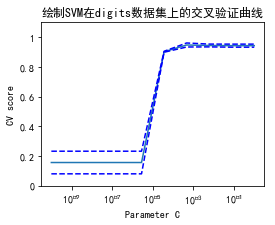

In [4]:
import numpy as np
from sklearn import model_selection, datasets, svm
import matplotlib.pyplot as plt

digits = datasets.load_digits()
x,y = digits.data, digits.target
svc = svm.SVC(kernel='linear')
c_s = np.logspace(-10, 0, 10)
print('参数列表长度', len(c_s))
scores_std = list()
scores = list()
for c in c_s:
    svc.C = c
    this_scores = model_selection.cross_val_score(svc, x, y, n_jobs=4)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
plt.figure(1, figsize=(4,3))
plt.clf()
plt.semilogx(c_s, scores)
plt.semilogx(c_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(c_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: '%g' % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0,1.1)
plt.title('绘制SVM在digits数据集上的交叉验证曲线')
plt.show()

##3.2 对每个输入数据点产生交叉验证估计
```
model_selection.cross_val_predict(estimator,x)
```

In [6]:
from sklearn import datasets,linear_model,model_selection

diabetes = datasets.load_diabetes()
x = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
y_pred = model_selection.cross_val_predict(lasso, x, y)
print(y_pred)
# 如果调用lasso.predict，那么就没有交叉验证的过程了

[ 174.26933996  117.6539241   164.60228641  155.65049088  132.68647979
  128.49511245  120.76146877  141.069413    164.18904498  182.37394949
  111.04181265  127.94311443  135.0869234   162.83066014  135.3573514
  157.64516523  178.95843326  163.3919841   143.85237903  144.29748882
  133.58117218  124.77928571  132.90918003  208.52927     153.61908967
  154.16616341  118.95351821  163.50467541  145.89406196  168.3308101
  155.87411031  123.45960148  185.70459144  133.38468582  117.2789469
  150.27895019  174.1541028   160.03235091  192.31389633  161.58568256
  154.2224809   119.35517679  146.15706413  133.82056934  179.68118754
  137.96619936  146.07788398  126.77579723  123.32101099  166.26710247
  146.41559964  161.67261029  147.47731459  138.44595305  144.85421048
  113.77990664  185.54970402  115.31624749  142.23672103  171.07792136
  132.5394716   177.80524864  116.5616502   134.25230846  142.88707475
  173.2830912   154.31273504  149.16680759  144.88238997  121.97783103
  110.384

###3.3 计算并绘制模型的学习率曲线
```
model_selection.learning_curve(estimator, x, y)
```

##3.4 计算并绘制模型的验证曲线
```
model_selection.validation_curve(estimator,...)
```

##3.5 通过排序评估交叉验证得分的重要性
```
model_selection.permutation_test_score(...)
```